# Grover Implementation
## Matvei Karp
02/13/2025

## The Problem

Given a boolean function f(x) which returns True for at least one value of x, find such an x.

### A note

Let n be the number of bits required to write the maximum value of x.

Let N be $2^n$

Let k be the number of values of x that return True.

Let w be the value that returns True

## Imports

### Importing Qiskit

Qiskit Itself

In [1]:
from qiskit import *

Visualisations

In [2]:
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_histogram

Simulators

In [3]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

### Importing other useful libraries

Numpy

*Python's scientific computing package*

In [4]:
import numpy as np

### Oracle and Diffuser functions

#### Grover Oracle

generates the oracle step for an n qubit main register.

    Parameters
    ----------
    n: int
        number of qubits in main register

    Returns
    -------
    Gate
        custom gate that applies the oracle step

In [5]:
def oracleGen(n):

    ## Creating the circuit
    oracleMain = QuantumRegister(n,"main")
    oracleAncilla = AncillaRegister(1, "ancilla")
    oracleCircuit = QuantumCircuit(oracleMain, oracleAncilla)

    ## Setting up the step
    oracleCircuit.mcx([main[0],main[1],main[2],main[3]],oracleAncilla)
    
    ## Converting to a Gate
    oracleGate = oracleCircuit.to_gate()
    oracleGate.name = "Oracle"
    return oracleGate

#### Grover Diffuser

generates the diffuser step for an n qubit main register

    Parameters
    ----------
    n: int
        number of qubits in main register

    Returns
    -------
    Gate
        custom gate that applies the diffuser step

In [6]:
def diffuserGen(n):

    ## Creating the circuit
    diffuserMain = QuantumRegister(n,"main")
    diffuserAncilla = AncillaRegister(1, "ancilla")
    diffuserCircuit = QuantumCircuit(diffuserMain, diffuserAncilla)

    ## Setting up the step
    diffuserCircuit.h(diffuserMain)
    diffuserCircuit.x(diffuserMain)
    diffuserCircuit.mcx(diffuserMain, diffuserAncilla)
    diffuserCircuit.x(diffuserMain)
    diffuserCircuit.h(diffuserMain)

    ## Converting to a Gate
    diffuserGate = diffuserCircuit.to_gate()
    diffuserGate.name = "Diffuser"
    return diffuserGate

## Quantum Subroutine

![Circuit Image](Grover.svg)

### Step 0: Choosing values

In [7]:
n = int(input("Input n, the max binary length of x: "))
k = int(input("Input k, the number of solutions: "))

Input n, the max binary length of x:  6
Input k, the number of solutions:  4


### Step 1: Creating the Registers

First, we need to create our quantum registers and our classical register.
$$\ket{\psi_1} = \ket{0}^{\otimes n}\otimes \ket{-}$$

In [8]:
main = QuantumRegister(n,"main")
ancilla = AncillaRegister(1, "ancilla")
creg = ClassicalRegister(n,"classical")
circuit = QuantumCircuit(main,ancilla,creg)

Prepare the ancilla register to the $\ket{-}$ state

In [9]:
circuit.x(ancilla)
circuit.h(ancilla)

We add a barrier to keep this step separate

In [10]:
circuit.barrier(main, ancilla)

The circuit after this stage

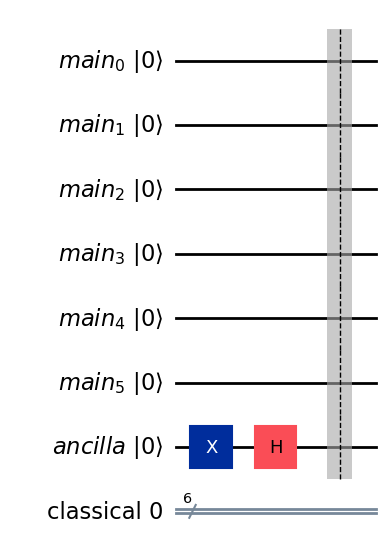

In [11]:
circuit.draw(initial_state=True, output="mpl")

### Step 2: Hadamard Gates

Next, we apply a hadamard gate to each qubit in the main register to represent all possible x.
$$\ket{\psi_2}=\ket{+}^{\otimes n}\otimes\ket{-}=\frac{1}{\sqrt{N}}\sum_{x=0}^{N}\ket{x}\otimes\ket{-}$$

In [12]:
circuit.h(main)

We add a barrier to keep this step separate

In [13]:
circuit.barrier(main, ancilla)

The circuit after this stage

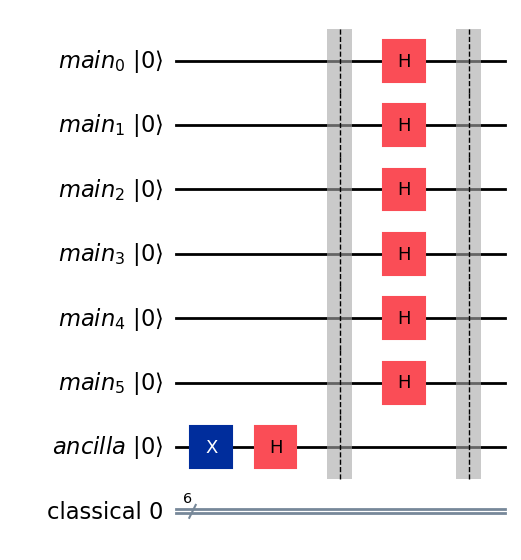

In [14]:
circuit.draw(initial_state=True, output="mpl")

### Step 3: Cycle

Next, we apply the oracle - diffuser cycle. Annoyingly, the number of times we should do this depends on the number of solutions (k).

The optimal number is: $$r=\frac{\pi\sqrt{\frac{N}{k}}}{4}$$

First we define the oracle and diffuser gates using the oracleGen and diffuserGen functions we created

Oracle:
$$U_{oracle}=I-2(\ket{w}\bra{w})$$
Diffuser:
$$U_{diffuser}=2(\ket{+}\bra{+})^{\otimes n}-I$$

In [15]:
oracle = oracleGen(n)
diffuser = diffuserGen(n)

The cycle:
$$G=U_{oracle}U_{diffuser}$$

Now we can repeat the cycle r times.

In [16]:
r = int(np.floor(np.pi*np.sqrt(2**n/k)/4))

In [17]:
for i in range(r):
    circuit.append(oracle, range(n+1))
    circuit.append(diffuser,range(n+1))

The new state after the cycle will be:
$$\ket{\psi_3}=G^r\ket{+}^{\otimes n}\otimes\ket{-}$$
If the r value is right:
$$\ket{\psi_3}\approx\ket{w}\otimes\ket{-}$$

We add a barrier to keep this step separate

In [18]:
circuit.barrier(main, ancilla)

The circuit after this stage

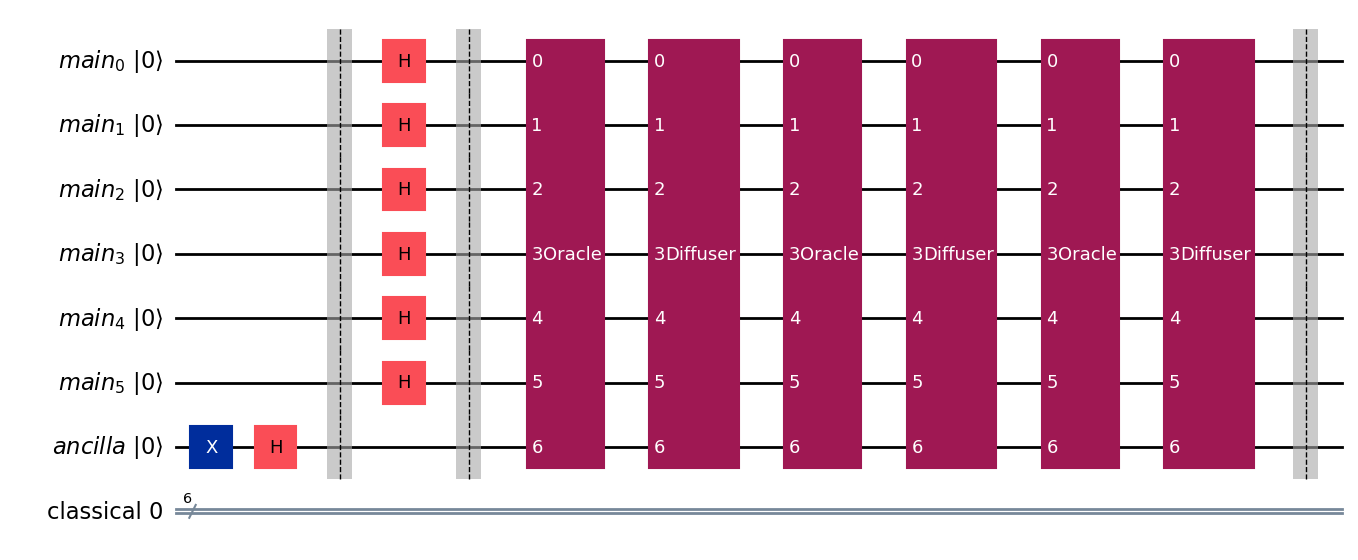

In [19]:
circuit.draw(initial_state=True, output="mpl")

### Step 4: Measure

We now measure the main register and discard the ancilla qubit (properly, we should return it to the $\ket{0}$ state).

In [20]:
circuit.measure(main,creg)

The circuit after this stage

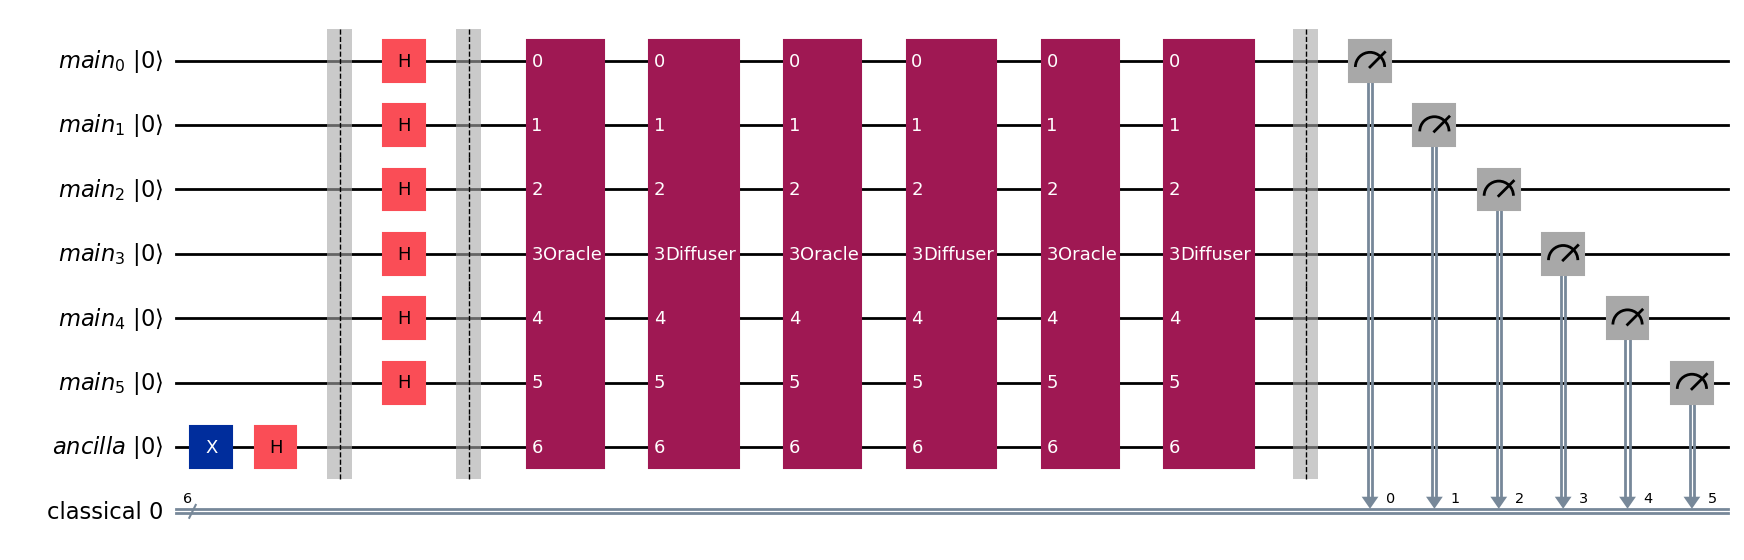

In [21]:
circuit.draw(initial_state=True, output="mpl")

## Execute
We now run the algorithm.

*This implementation does not implement noise, so the distribution is more exact than it really would be*

### Make a copy of the setup

In [22]:
circ = circuit.copy()

### Define which simulator to use

In [23]:
aersim = AerSimulator()

### We then transpile this copy

In [24]:
circTranspiled = transpile(circ,aersim)

### Run in the Qiskit Aer Simulator

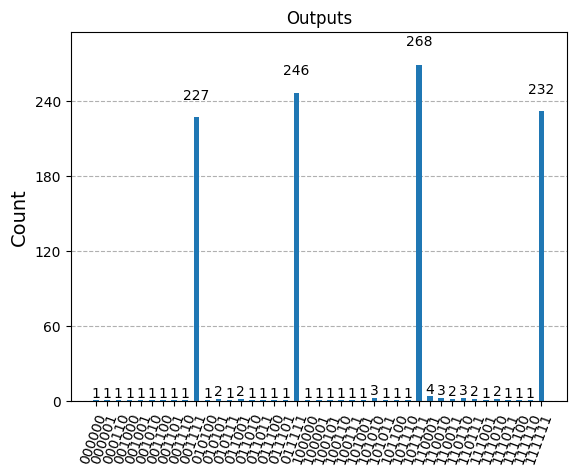

In [25]:
result_ideal = aersim.run(circTranspiled, shots=1024).result()
counts_ideal = result_ideal.get_counts(0)
plot_histogram(counts_ideal, title='Outputs')

## Interpreting

We now proccess the outputs

We want to limit our counts to the k greatest counts

The counts come out in the form of a dictionary with the measured states as the keys

In [26]:
print(counts_ideal)

{'100110': 1, '001101': 1, '110011': 2, '100101': 1, '110111': 2, '010101': 2, '111010': 2, '111001': 1, '110010': 3, '111110': 1, '111100': 1, '011100': 1, '010100': 1, '010111': 1, '111011': 1, '101111': 268, '000001': 1, '000110': 1, '101011': 1, '000000': 1, '011001': 2, '100000': 1, '110001': 4, '111111': 232, '011010': 1, '001001': 1, '100001': 1, '011011': 1, '011111': 246, '100111': 1, '001000': 1, '001100': 1, '101100': 1, '001111': 227, '101010': 3, '001110': 1, '101001': 1, '011101': 1, '110110': 3, '101110': 1, '001010': 1}


### Swap keys and counts
Since we want to sort by count and not by key, we flip the two

In [27]:
swapped = [(value, key) for key, value in counts_ideal.items()]
print(swapped)

[(1, '100110'), (1, '001101'), (2, '110011'), (1, '100101'), (2, '110111'), (2, '010101'), (2, '111010'), (1, '111001'), (3, '110010'), (1, '111110'), (1, '111100'), (1, '011100'), (1, '010100'), (1, '010111'), (1, '111011'), (268, '101111'), (1, '000001'), (1, '000110'), (1, '101011'), (1, '000000'), (2, '011001'), (1, '100000'), (4, '110001'), (232, '111111'), (1, '011010'), (1, '001001'), (1, '100001'), (1, '011011'), (246, '011111'), (1, '100111'), (1, '001000'), (1, '001100'), (1, '101100'), (227, '001111'), (3, '101010'), (1, '001110'), (1, '101001'), (1, '011101'), (3, '110110'), (1, '101110'), (1, '001010')]


### Sort and cut off
We now sort the swapped list and save the first k tuples

In [28]:
firstValues = sorted(swapped, reverse = True)[:k]
print(firstValues)

[(268, '101111'), (246, '011111'), (232, '111111'), (227, '001111')]


### Turn it into just a list of the states
Since we now take only the second element element from each tuple

In [29]:
values = [p[1] for p in firstValues]
print(values)

['101111', '011111', '111111', '001111']


### Take the values out of binary
We now convert the states into base 10 and sort them

In [30]:
outputValues = sorted([int(v,2) for v in values])
print(outputValues)

[15, 31, 47, 63]


## Final Result

In [31]:
print("f(x) returns true when x is in the set ",end="{")
for i in range(k-1):
    print(outputValues[i], end=", ")
print(str(outputValues[k-1])+"}")

f(x) returns true when x is in the set {15, 31, 47, 63}
